In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from datetime import datetime
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow_docs.modeling import EpochDots

%load_ext tensorboard

In [2]:
train_df = pd.read_csv("data/Train_dataset.csv")
test_df = pd.read_csv("data/Test_dataset.csv")

In [3]:
train_df = train_df[:10714]

In [4]:
train_df = train_df.drop(['Designation', 'Name', 'Insurance', 'salary'], axis=1)
test_df = test_df.drop(['Designation', 'Name', 'Insurance', 'salary'], axis=1)

In [5]:
train_df = train_df.dropna()

In [6]:
cat_cols = ['Region', 'Gender', 'Married', 'Occupation', 'Mode_transport', 'comorbidity', 'cardiological pressure', 'Pulmonary score']
for i in cat_cols:
    train_df[i] = train_df[i].astype('category')
    train_df[i] = train_df[i].cat.codes
    test_df[i] = test_df[i].astype('category')
    test_df[i] = test_df[i].cat.codes

In [7]:
train_dataset = train_df.drop('people_ID', axis=1)
test_dataset = test_df.drop('people_ID', axis=1)

In [8]:
for i in test_dataset.columns:
    train_dataset[i] = train_dataset[i].astype(int)
    test_dataset[i] = test_dataset[i].astype(int)

In [9]:
train_stats = train_dataset.describe()
train_stats.pop("Infect_Prob")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Region,7052.0,1.566081,1.186855,0.0,1.0,2.0,3.00,4.0
Gender,7052.0,0.496597,0.500024,0.0,0.0,0.0,1.00,1.0
Married,7052.0,0.776659,0.416515,0.0,1.0,1.0,1.00,1.0
Children,7052.0,0.964833,0.719018,0.0,0.0,1.0,1.00,2.0
Occupation,7052.0,4.054594,2.556911,0.0,2.0,4.0,6.00,8.0
Mode_transport,7052.0,1.018576,0.818916,0.0,0.0,1.0,2.00,2.0
cases/1M,7052.0,3.314663,2.749886,1.0,2.0,2.0,4.00,8.0
Deaths/1M,7052.0,0.527935,0.863175,0.0,0.0,0.0,1.00,2.0
comorbidity,7052.0,1.497306,1.118617,0.0,0.0,1.0,2.00,3.0
Age,7052.0,42.195406,15.767774,16.0,28.0,45.0,55.00,68.0


In [10]:
train_labels = train_dataset.pop('Infect_Prob')
test_labels = test_dataset

In [11]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [12]:
def build_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])
    
    return model

In [13]:
model = build_model()

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1472      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,697
Trainable params: 5,697
Non-trainable params: 0
_________________________________________________________________


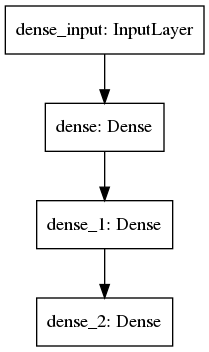

In [15]:
plot_model(model, to_file='model.png')

In [16]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)
earlystopping_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

history = model.fit(normed_train_data, train_labels, epochs=5, validation_split=0.2, callbacks=[tensorboard_callback])

Train on 5641 samples, validate on 1411 samples
Epoch 1/5
5641/5641 [==============================] - 1s 133us/sample - loss: 1077.9362 - mae: 26.3992 - mse: 1077.9362 - val_loss: 159.8156 - val_mae: 9.3246 - val_mse: 159.8156
Epoch 2/5
5641/5641 [==============================] - 0s 69us/sample - loss: 107.1238 - mae: 6.8032 - mse: 107.1237 - val_loss: 138.6096 - val_mae: 8.2038 - val_mse: 138.6096
Epoch 3/5
5641/5641 [==============================] - 0s 58us/sample - loss: 100.0652 - mae: 6.3716 - mse: 100.0651 - val_loss: 121.0291 - val_mae: 7.3038 - val_mse: 121.0292
Epoch 4/5
5641/5641 [==============================] - 0s 61us/sample - loss: 96.1807 - mae: 6.1220 - mse: 96.1807 - val_loss: 122.5807 - val_mae: 7.2917 - val_mse: 122.5807
Epoch 5/5
5641/5641 [==============================] - 0s 56us/sample - loss: 93.2949 - mae: 5.9628 - mse: 93.2950 - val_loss: 117.1357 - val_mae: 7.0584 - val_mse: 117.1357


In [17]:
model.save('weights.h5')

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,1077.936242,26.399244,1077.936157,159.815614,9.324611,159.815613,0
1,107.123753,6.803202,107.123726,138.609628,8.203809,138.609634,1
2,100.065180,6.371603,100.065147,121.029146,7.303820,121.029160,2
3,96.180734,6.122001,96.180740,122.580742,7.291659,122.580742,3
4,93.294946,5.962793,93.294960,117.135744,7.058405,117.135727,4


In [21]:
test_predictions = model.predict(normed_test_data).flatten()

In [25]:
pred_df = pd.read_csv('data/Prediction.csv')

In [26]:
pred_df.head()

,people_ID,Region,Gender,Designation,Name,Married,Children,Occupation,Mode_transport,cases/1M,...,Platelets,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month
0,5942,Delhi,Female,Mrs,smt rekha prajapat,YES,2,Driver,Public,4,...,153,196,240,85,53,17,3,3900000,1300000,1
1,18664,Delhi,Male,Mr,nirmal,YES,2,Legal,Walk,4,...,95,138,241,81,61,2,5,1800000,1300000,1
2,5603,Delhi,Female,Mrs,pinky,YES,2,Sales,Car,4,...,40,166,236,88,47,24,3,5000000,2000000,2
3,5649,Delhi,Female,Mrs,pooja @aafrin,YES,2,Sales,Car,4,...,78,83,211,87,52,13,6,3100000,600000,2
4,5099,Delhi,Female,Mrs,anjali,YES,2,Business,Car,4,...,109,207,312,94,68,39,5,2300000,1500000,1


In [27]:
pred_df['Infect_Prob'] = test_predictions

In [28]:
pred_df.head()

,people_ID,Region,Gender,Designation,Name,Married,Children,Occupation,Mode_transport,cases/1M,...,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month,Infect_Prob
0,5942,Delhi,Female,Mrs,smt rekha prajapat,YES,2,Driver,Public,4,...,196,240,85,53,17,3,3900000,1300000,1,53.901024
1,18664,Delhi,Male,Mr,nirmal,YES,2,Legal,Walk,4,...,138,241,81,61,2,5,1800000,1300000,1,50.199066
2,5603,Delhi,Female,Mrs,pinky,YES,2,Sales,Car,4,...,166,236,88,47,24,3,5000000,2000000,2,57.751297
3,5649,Delhi,Female,Mrs,pooja @aafrin,YES,2,Sales,Car,4,...,83,211,87,52,13,6,3100000,600000,2,55.574390
4,5099,Delhi,Female,Mrs,anjali,YES,2,Business,Car,4,...,207,312,94,68,39,5,2300000,1500000,1,54.728168


In [31]:
pred1_df = pred_df[['people_ID', 'Infect_Prob']]

In [32]:
pred1_df.head()

,people_ID,Infect_Prob
0,5942,53.901024
1,18664,50.199066
2,5603,57.751297
3,5649,55.574390
4,5099,54.728168


In [34]:
pred1_df.to_csv('data/output01.csv', index=False)